In [1]:
import os

In [2]:
os.chdir(os.path.split(os.getcwd())[0])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent import *
from optionpricing import *
import yaml
import torch
from collections import defaultdict

In [4]:
import matplotlib.style as style

In [5]:
style.use('seaborn-poster')

In [22]:
experiment_folder = 'Exp_Oct11_g0.3_bs128_clip100'

In [23]:
with open(os.path.join('experiments', experiment_folder, 'config.yaml'), 'r') as f:
    args_dict = yaml.load(f, Loader = yaml.SafeLoader)

In [24]:
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [25]:
args = Args(**args_dict)

In [26]:
config = {
        'S': 100,
        'T': 10, # 10 days
        'L': 1,
        'm': 100, # L options for m stocks
        'n': 0,
        'K': 100,
        'D': 5,
        'mu': 0,
        'sigma': 0.01,
        'r': 0,
        'ss': 5,
        'kappa': 0.1,
        'multiplier': args.trc_multiplier,
        'ticksize': args.trc_ticksize
        }

env = OptionPricingEnv()
env.configure(**config)

AttributeError: 'Args' object has no attribute 'trc_multiplier'

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ngpu = 1 if torch.cuda.is_available() else 0

In [27]:
def load_estimator(env, device, ngpu, experiment_folder, kind = 'best'):
    state_shape = env.observation_space.shape
    state_space_dim = state_shape[0] if len(state_shape) == 1 else state_shape
    
    estimator = Estimator(ngpu, state_space_dim, env.action_space.n)
    if kind == 'best':
        checkpoint = torch.load(os.path.join('experiments', experiment_folder, 'best.pth'), map_location = torch.device('cpu'))
    elif kind == 'checkpoint':
        checkpoint = torch.load(os.path.join('experiments', experiment_folder, 'checkpoint.pth'), map_location = torch.device('cpu'))
    else:
        raise ValueError('Invalid choice for kind')
        
    estimator.load_state_dict(checkpoint['estimator'])
    estimator.eval()
    
    return estimator

In [28]:
def simulate_episode(env, device, estimator):
    
    state = torch.from_numpy(env.reset()).to(device)
    history = defaultdict(list)
    #history['delta'].append(env.delta)
    #history['stock_pnl'].append(0)
    #history['option_pnl'].append(0)
    #history['total_pnl'].append(0)
    #history['stock_value'].append(env.stock_value)
    #history['option_value'].append(env.option_value)
    #history['cash'].append(env.cash)
    done = False
    
    while not done:
        history['delta'].append(env.delta)
        with torch.no_grad():
            action = np.argmax(estimator(state).numpy())
        state, reward, done, info = env.step(action)
        
        history['reward'].append(reward)
        history['n'].append(env.n)
        history['stock_value'].append(env.stock_value)
        history['option_value'].append(env.option_value)
        history['cash'].append(env.cash)
        #history['stock_pnl'].append(history['stock_value'][-1] - history['stock_value'][-2])
        #history['option_pnl'].append(history['option_value'][-1] + history['cash'][-1] - history['option_value'][-2] - history['cash'][-2])
        #history['total_pnl'].append(history['stock_pnl'] + history['option_pnl'])
        
        state = torch.from_numpy(state).to(device)
        
    return history

In [29]:
estimator = load_estimator(env, device, ngpu, experiment_folder, 'best')

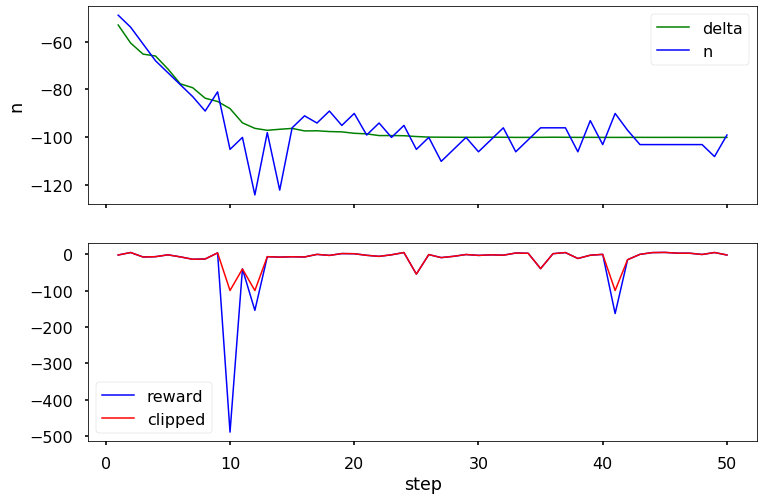

In [33]:
history = simulate_episode(env, device, estimator)

stock_pnl = np.array(history['stock_value'][1:]) - np.array(history['stock_value'][:-1])
stock_pnl = np.insert(stock_pnl, 0, 0)

option_pnl = np.array(history['option_value'][1:]) + np.array(history['cash'][1:]) - np.array(history['option_value'][:-1]) - np.array(history['cash'][:-1])
option_pnl = np.insert(option_pnl, 0, 0)

total_pnl = stock_pnl + option_pnl

steps = np.arange(1, len(history['delta']) + 1, 1)

fig, ax = plt.subplots(figsize = (12, 8), nrows = 2, ncols = 1, sharex = True)
ax[0].plot(steps, np.array(history['delta']) * -env.L * env.m, color = 'green', label = 'delta', lw = 1.5)
ax[0].plot(steps, history['n'], color = 'blue', label = 'n', lw = 1.5)
ax[0].legend()
#ax[1].plot(steps, history['cash'], color = 'red', label = 'cash', lw = 1.5)
ax[1].plot(steps, history['reward'], color = 'blue', label = 'reward', lw = 1.5)
ax[1].plot(steps, np.clip(history['reward'], -args.clip, args.clip), color = 'red', label = 'clipped', lw = 1.5)
#ax.plot(steps, total_pnl, lw = 1.5, label = 'total pnl', color = 'red')
ax[1].set_xlabel('step')
ax[0].set_ylabel('n')
plt.legend()
plt.show()